In [2]:
cd ..

/home/pierre/git/semisupervised


In [515]:
import os
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import torch
import imageio
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from module.objective import get_objective
import scipy
from module.plot_script import plot_gp_fit
from module.utils import standardize_return, _is_in_ellipse
from torch.distributions.multivariate_normal import MultivariateNormal
import scipy.stats as stats

from gpytorch.kernels import RBFKernel
from gpytorch.kernels.scale_kernel import ScaleKernel
from gpytorch.priors.torch_priors import GammaPrior
from botorch.models import SingleTaskGP
from botorch.utils.transforms import standardize

def plot_distribution_1D(ax, iteration, data, bound=5.):
    x = np.linspace(-bound, bound, 10000)
    mu, covar = data["mu"][iteration], data["sigma"][iteration].reshape(1,1)
    distribution = MultivariateNormal(mu, covar)
    y_lim = ax.get_ylim()
    X = data["X"]
    X = X.reshape(-1, 3)[iteration].reshape(-1,1)
    ax.plot(x, y_lim[0] + (1/min(y_lim[1] - y_lim[0], stats.norm.pdf(distribution.loc.cpu().detach().numpy(), distribution.loc.cpu().detach().numpy(), distribution.covariance_matrix.cpu().detach().numpy())[0,0]))*(y_lim[1] - y_lim[0])*stats.norm.pdf(x, distribution.loc.cpu().detach().numpy(), distribution.covariance_matrix.cpu().detach().numpy()).flatten(), "k")
    ax.scatter(X.cpu().numpy(), np.zeros(X.shape[0]) + y_lim[0], color='red', label = "sampled points")
    ax.axis('off')

def plot_function(ax, objective, lb = -2., up = 2.):
    X_test = torch.linspace(lb, up, 1000).reshape(-1, 1)
    y_test = objective(X_test)
    ax.plot(X_test, y_test, color='green', label='True Function')

def plot_gp_fit(ax, model, train_X, targets, obj, bound = 5.):
    """Plot the gp fit, normalize parameter in case of input normalization"""
    lb, up = -bound, bound
    
    model.eval()
    model.likelihood.eval()

    test_x = torch.linspace(lb, up, 500, device=train_X.device, dtype=train_X.dtype)
    
    with torch.no_grad():
        # Make predictions
        predictions = model.likelihood(model(test_x))
        lower, upper = predictions.confidence_region()
    _, mean_Y, std_Y = standardize_return(targets)
    lower, upper = lower*float(std_Y) + float(mean_Y), upper*float(std_Y) + float(mean_Y)
    
    value_test = (obj(test_x.unsqueeze(-1))).flatten()

    ax.plot(test_x.cpu().numpy(), predictions.mean.cpu().numpy()*float(std_Y) + float(mean_Y), color='blue', label='Predictive mean')
    ax.plot(test_x.cpu().numpy(), value_test.cpu().numpy(), color='green', label='True Function')
    ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), color='lightblue', alpha=0.5, label='Confidence region')

def plot_iteration_probes(ax, iteration, data, obj, bound):
    """Here iteration=1 means showing initial data + gp fit on it + first optimised batch"""
    X = data["X"]
    X = X.reshape(-1, 3)[:iteration].reshape(-1,1)
    mu, covar = data["mu"][iteration], data["sigma"][iteration]
    distribution = MultivariateNormal(mu, covar)
    state_dict = data["list_models"][iteration - 1]
    covar_module = ScaleKernel(
            RBFKernel(
                ard_num_dims=X.shape[-1],
                batch_shape=None,
                lengthscale_prior=GammaPrior(X.shape[-1], np.sqrt(X.shape[-1])),
            ),
            batch_shape=None,
            outputscale_prior=GammaPrior(6.0, 3.0),
        )
    mask = _is_in_ellipse(distribution.loc, distribution.covariance_matrix, X, np.sqrt(scipy.stats.chi2.ppf(q=0.9973,df=X.shape[-1])))
    train_x = X[mask]
    train_y = obj(X).reshape(-1, 1)[mask]
    train_y_init_standardized = standardize(train_y)
    # train_y_standardized_mean = train_y.mean()
    # train_y_standardized_std = train_y.std()
    
    model = SingleTaskGP(train_x, train_y_init_standardized, covar_module=covar_module).to(train_x)
    model.load_state_dict(state_dict, strict=True)
    plot_gp_fit(ax, model, train_x, train_y, obj, bound)
    ax.scatter(X.cpu().numpy(), obj(X).reshape(-1, 1).cpu().numpy(), color='grey', label = "passive points")
    ax.scatter(train_x.cpu().numpy(), train_y.cpu().numpy(), color='black', label = "active points")
    ax.axis('off')

def plot_iteration_es(ax, iteration, data, obj, bound):
    """Here iteration=1 means showing initial data + gp fit on it + first optimised batch"""
    X = data["X"]
    X = X.reshape(-1, 3)[:iteration].reshape(-1,1)
    
    train_x = X
    train_y = obj(X).reshape(-1, 1)

    test_x = torch.linspace(-bound, bound, 500, device=train_x.device, dtype=train_y.dtype)
    value_test = (obj(test_x.unsqueeze(-1))).flatten()
    ax.plot(test_x.cpu().numpy(), value_test.cpu().numpy(), color='green', label='True Function')

    ax.scatter(X.cpu().numpy(), obj(X).reshape(-1, 1).cpu().numpy(), color='grey')
    ax.scatter(train_x.cpu().numpy(), train_y.cpu().numpy(), color='black')
    ax.axis('off')

In [518]:
def plot_integral(fig, ax, objective, bound=3., N=10000):
    b = np.arange(-bound,bound + 0.01, 0.01)
    # b = np.arange(-bound,bound + 0.1, 0.1)
    d = np.arange(0, 1.5, 0.005)[1:]
    # d = np.arange(0, 1.5, 0.05)[1:]
    d = np.hstack(([1e-6, 1e-5, 1e-4, 1e-3], d))
    B, D = np.meshgrid(b, d)
    n, m = b.shape[0], d.shape[0]
    res = torch.stack((torch.tensor(B.flatten()), torch.tensor(D.flatten())), axis = 1).cpu().numpy()
    result = []
    
    for el in res:
        mean = el[0]
        std = el[1]
        distribution = MultivariateNormal(torch.tensor([mean]).to(device=objective.device, dtype=objective.dtype), torch.tensor([[std**2]]).to(device=objective.device, dtype=objective.dtype))
        samples = distribution.sample((N, ))
        values = objective(samples)
        estimate = values.mean(dim = 0)
        result.append(estimate)

    mean = torch.tensor(result).cpu().numpy().reshape(m,n)
    contour = ax.contourf(B, D, mean)

    ax.set_xlabel(r'$\mu$')
    ax.set_ylabel(r'$\sigma$')
    fig.colorbar(contour, ax=ax, orientation="horizontal", pad=0.1)
    # fig.colorbar(contour, ax=ax, orientation="horizontal", pad=0.1)
    # axins = inset_axes(ax,
    #                 width="100%",  
    #                 height="5%",
    #                 loc='lower center',
    #                 borderpad=-5
    #                )
    # fig.colorbar(im, cax=axins, orientation="horizontal")
    


def plot_trajectory(ax, data_probes, data_es):
    ax.scatter(np.array(data_probes["mu"]).flatten(), np.sqrt(np.array(data_probes["sigma"]).flatten()))
    ax.scatter(np.array(data_es["mu"]).flatten(), np.sqrt(np.array(data_es["sigma"]).flatten()))

In [413]:
np.sqrt(np.array(data_es["sigma"]).flatten())

array([1.        , 0.62281876, 0.39935505, 0.47961407, 0.63453902,
       1.35634389, 0.90821311, 1.27582892, 1.00156118, 1.17069707,
       0.81052708, 0.54309695, 0.34507069, 0.26533308, 0.17202019,
       0.10839795, 0.06843471, 0.04457801, 0.02861793, 0.03597907,
       0.02374425, 0.01643265, 0.01292281, 0.00844581, 0.00530781,
       0.00571337, 0.00488811, 0.00347485, 0.00267903, 0.00407241,
       0.00257631])

In [409]:
np.array(data["mu"]).flatten()

array([-1.00000000e+00, -9.99999965e-01, -9.17009629e-01, -5.66217273e-01,
       -4.17077072e-02, -4.74490905e-02, -4.74064087e-02, -4.75265859e-03,
       -9.29161489e-04, -1.33090576e-03, -4.20295883e-03,  3.81262254e-04,
        1.47135434e-03, -1.36694995e-04, -2.34862689e-03, -2.71121389e-04,
        8.89397580e-05, -5.86476329e-05,  9.68299084e-05, -2.34732553e-05,
        1.35191802e-04,  2.45509336e-06,  7.80421232e-05,  7.12718801e-05,
        5.76903907e-05,  4.08234017e-05,  2.00354718e-05,  1.09419369e-04,
       -8.99435861e-05, -4.69128440e-06,  1.73149588e-05])

In [320]:
seed = 4
label, device, dtype, problem_kwargs = "test_function", "cpu", torch.double, {"function": "ackley", "noise_std": 0., "dim": 1, "initial_bounds": 10.}
data_path_probes = "./logs/test_function/ackley_noise_std-0.0_dim-1_initial_bounds-10.0/probES/type-XNES_policy-constant_gradient-expected_aqc_typef-random_mahalanobis-True_mean_prior--1.0_std_prior-2.0_lr-1.0_batch_size-2/seed-{:04d}.pt".format(seed)
with open(data_path_probes, "rb") as fp:
    data_probes = torch.load(data_path_probes, map_location="cpu")

data_path_es = "./logs/test_function/ackley_noise_std-0.0_dim-1_initial_bounds-10.0/ES/type-XNES_mean_prior--1.0_std_prior-2.0_batch_size-2/seed-{:04d}.pt".format(seed)
with open(data_path_es, "rb") as fp:
    data_es = torch.load(data_path_es, map_location="cpu")


obj = get_objective(label=label, device=device, dtype=dtype, problem_kwargs=problem_kwargs)

/tmp/ipykernel_5014/3147859562.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_probes = torch.load(data_path_probes, map_location="cpu")
/tmp/ipykernel_5014/3147859

RuntimeError: shape '[-1, 3]' is invalid for input of size 62

/home/pierre/miniconda3/envs/semisupervised_v2/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/pierre/miniconda3/envs/semisupervised_v2/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/pierre/miniconda3/envs/semisupervised_v2/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/pierre/miniconda3/envs/semisu

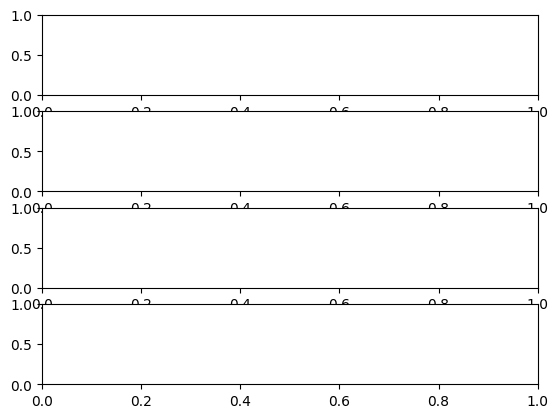

In [321]:
fig, axs = plt.subplots(nrows=4)
iteration = 2
plot_iteration_probes(axs[0], iteration, data_probes, obj, bound = 5.)
plot_distribution_1D(axs[1], iteration, data_probes, bound=5.)

plot_iteration_es(axs[2], iteration, data_es, obj, bound = 5.)
plot_distribution_1D(axs[3], iteration, data_es, bound=5.)

In [346]:
seed = 6
label, device, dtype, problem_kwargs = "test_function", "cpu", torch.double, {"function": "ackley", "noise_std": 0., "dim": 1, "initial_bounds": 10.}
data_path_probes = "./logs/test_function/ackley_noise_std-0.0_dim-1_initial_bounds-10.0/probES/type-CMAES_policy-constant_gradient-expected_aqc_typef-random_mahalanobis-True_mean_prior--1.0_std_prior-1.0_lr-1.0_batch_size-3/seed-{:04d}.pt".format(seed)
with open(data_path_probes, "rb") as fp:
    data_probes = torch.load(data_path_probes, map_location="cpu")

data_path_es = "./logs/test_function/ackley_noise_std-0.0_dim-1_initial_bounds-10.0/ES/type-CMAES_mean_prior--1.0_std_prior-1.0_batch_size-3/seed-{:04d}.pt".format(seed)
with open(data_path_es, "rb") as fp:
    data_es = torch.load(data_path_es, map_location="cpu")


obj = get_objective(label=label, device=device, dtype=dtype, problem_kwargs=problem_kwargs)

/tmp/ipykernel_5014/1902644028.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_probes = torch.load(data_path_probes, map_location="cpu")
/tmp/ipykernel_5014/1902644

/home/pierre/miniconda3/envs/semisupervised_v2/lib/python3.11/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/home/pierre/miniconda3/envs/semisupervised_v2/lib/python3.11/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/home/pierre/miniconda3/envs/semisupervised_v2/lib/python3.11/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/home/pierre/miniconda3/envs/semisupervised_v2/lib/python3.11/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scali

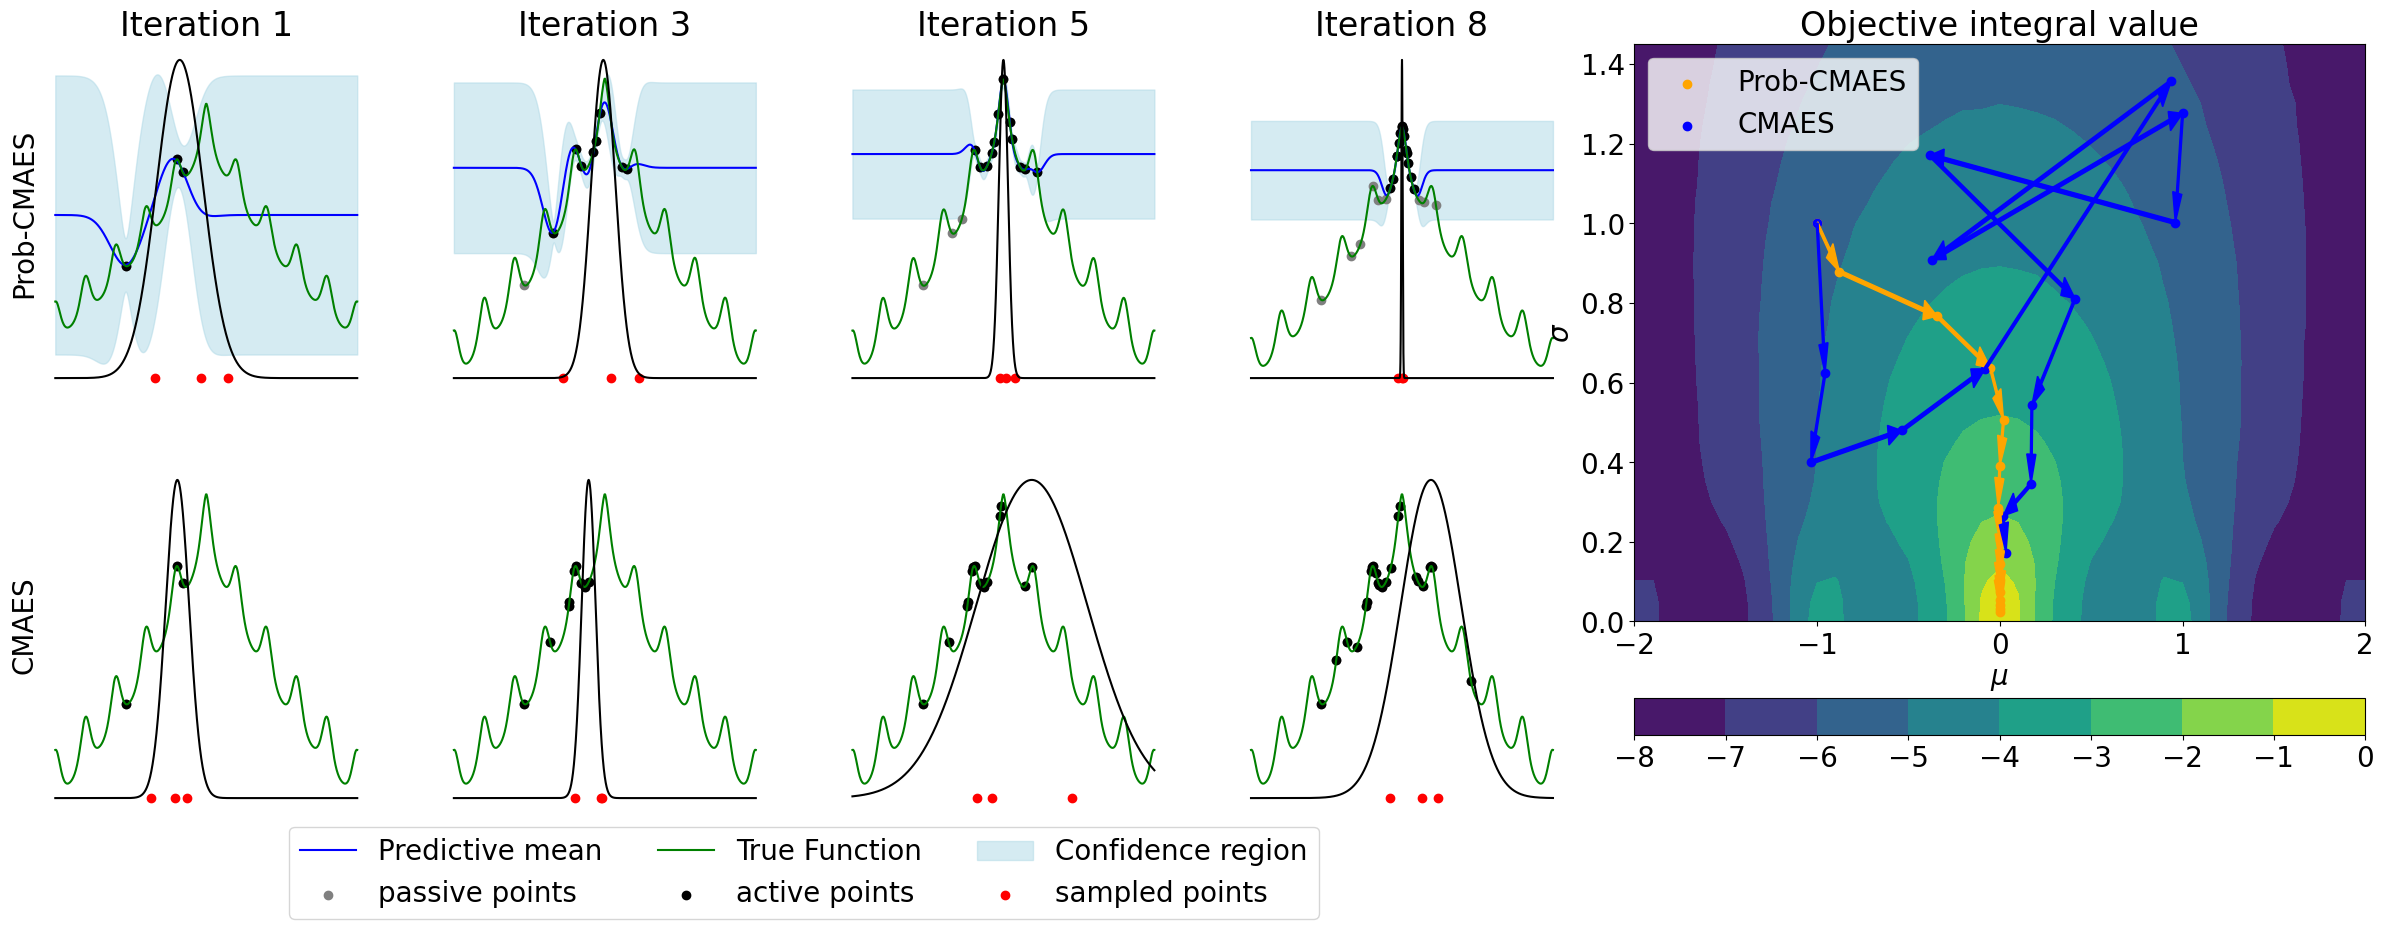

In [523]:
plt.rcParams.update({'font.size': 20})
fig, axs = plt.subplots(nrows=2, ncols=6,figsize=(30, 10))

gs = axs[0, 4].get_gridspec()
# remove the underlying Axes
for ax in axs[:, 4]:
    ax.remove()
for ax in axs[:, 5]:
    ax.remove()
axbig = fig.add_subplot(gs[:, 4:])

iteration = 1
plot_iteration_probes(axs[0, 0], 1, data_probes, obj, bound = 5.)
plot_distribution_1D(axs[0, 0], 1, data_probes, bound=5.)
axs[0, 0].set_title("Iteration 1")
axs[0, 0].text(-6.5, -7, "Prob-CMAES", rotation=90, va='center')

plot_iteration_es(axs[1, 0], 1, data_es, obj, bound = 5.)
plot_distribution_1D(axs[1, 0], 1, data_es, bound=5.)
axs[1, 0].text(-6.5, -6.5, "CMAES", rotation=90, va='center')

plot_iteration_probes(axs[0, 1], 3, data_probes, obj, bound = 5.)
plot_distribution_1D(axs[0, 1], 3, data_probes, bound=5.)
axs[0, 1].set_title("Iteration 3")

plot_iteration_es(axs[1, 1], 3, data_es, obj, bound = 5.)
plot_distribution_1D(axs[1, 1], 3, data_es, bound=5.)


plot_iteration_probes(axs[0, 2], 5, data_probes, obj, bound = 5.)
plot_distribution_1D(axs[0, 2], 5, data_probes, bound=5.)
axs[0, 2].set_title("Iteration 5")

handles,labels = axs[0, 2].get_legend_handles_labels()
reordering = [0, 3, 1, 4, 2, 5]
handles = [handles[i] for i in reordering]
labels = [labels[i] for i in reordering]

axs[0, 2].legend(handles,labels,loc = (-1.65,-1.5), ncol=3)

plot_iteration_es(axs[1, 2], 5, data_es, obj, bound = 5.)
plot_distribution_1D(axs[1, 2], 5, data_es, bound=5.)

plot_iteration_probes(axs[0, 3], 8, data_probes, obj, bound = 5.)
plot_distribution_1D(axs[0, 3], 8, data_probes, bound=5.)
axs[0, 3].set_title("Iteration 8")

plot_iteration_es(axs[1, 3], 8, data_es, obj, bound = 5.)
plot_distribution_1D(axs[1, 3], 8, data_es, bound=5.)

plot_integral(fig, axbig, obj, bound=2., N=100000)
# plot_trajectory(axbig, data_probes, data_es)

mu_probes, sigma_probes = np.array(data_probes["mu"][:15]).flatten(), np.sqrt(np.array(data_probes["sigma"][:15]).flatten())
axbig.scatter(mu_probes, sigma_probes, color = "orange", label = "Prob-CMAES")

mu_es, sigma_es = np.array(data_es["mu"][:15]).flatten(), np.sqrt(np.array(data_es["sigma"][:15]).flatten())
axbig.scatter(mu_es, sigma_es, color = "blue", label = "CMAES")
# axbig.set_yticks(list(axbig.get_yticks()) + [0.])
axbig.set_ylim(bottom = 0., top = 1.45)
axbig.set_title("Objective integral value")
axbig.legend(loc = "upper left")


for i in range(14):
    axbig.arrow(mu_probes[i], sigma_probes[i], mu_probes[i+1] - mu_probes[i], sigma_probes[i+1] - sigma_probes[i], width = 0.01, color = "orange",head_width=0.05, length_includes_head = True)
    axbig.arrow(mu_es[i], sigma_es[i], mu_es[i+1] - mu_es[i], sigma_es[i+1] - sigma_es[i], width = 0.01, color = "blue", head_width = 0.05, length_includes_head = True)

fig.savefig("illustration.pdf", bbox_inches='tight')